In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # shut up tensorflow debug messages

# Force use CPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from datetime import datetime
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


def fix_ts():
    """ ts format: YYYY-MM-DDThh:mm:ss """

    return datetime.now().isoformat().split('.')[0]


def log(s):
    """ Print a LOG message """

    print('[LOG ' + fix_ts() + '] ' + s)


def line2list(line):
    return line.strip().split(',')


def get_limits(feature, samples):
    """ Given a feature, get the minimal and maximal values """

    vals_this_feature = [sample[feature] for sample in samples.values()]

    return np.min(vals_this_feature), np.max(vals_this_feature)


def norm(val, low, high, new_low=0, new_high=1):
    """ Linearly scale a value from range <low, high> into
        a new range <new_low, new_high>
    """

    return (new_high - new_low) / (high - low) * (val - low) + new_low


def read_data(data_file):
    """ Read and normalize data
    returns: samples, targets (dicts keyed by a sample index)
    sample: dict keyed by a feature name
    target: binary value of {0, 1}
    """

    samples = {}
    targets = {}

    # Read data (encoding='utf-8-sig' => omit BOM)
    with open(data_file, 'r', encoding='utf-8-sig') as cfr:

        # Read feature names (CSV header), last col ~ target
        features = line2list(cfr.readline())[:-1]

        # Read samples and targets, add them to dicts (key ~ index)
        for ind, line in enumerate(cfr.readlines()):
            vals = line2list(line)

            # Feature vector representing a sample
            samples[ind] = {feature: float(val) for feature, val in zip(features, vals[:-1])}

            # Corresponding target
            targets[ind] = float(vals[-1])

    # Get limits and normalize samples

    for feature in features:
        low, high = get_limits(feature, samples)
        for sample in samples.values():
            sample[feature] = norm(sample[feature], low, high)

    return samples, targets, sorted(features)


def show_data_stats(samples, targets, print_data=False):
    """ Print out some data stats """

    if print_data:
        for ind in samples.keys():
            print('{}\t{}\t{}'.format(ind, targets[ind], [(f, round(val, 2)) for f, val in samples[ind].items()]))


def split_data(targets, split_ratio=(0.8, 0.1, 0.1), seed=1):
    """ Split data to disjunctive sets: train, dev, test
        return: dict
            keys: 'train', 'dev', 'test
            values: list of samples indices
    """

    split = {'train': [], 'dev': [], 'test': []}

    # Set random seed for shuffling this split
    np.random.seed(seed)

    ## Carefully and equally distribute positive and negative samples
    negs = [ind for ind, val in targets.items() if val == 0.0]
    poss = [ind for ind, val in targets.items() if val == 1.0]

    for kind in (negs, poss):
        np.random.shuffle(kind)
        for i, ind in enumerate(kind):
            if i / len(kind) < split_ratio[0]:
                split['train'].append(ind)
            elif split_ratio[0] < i / len(kind) < split_ratio[0] + split_ratio[1]:
                split['dev'].append(ind)
            else:
                split['test'].append(ind)

    return split


def form_data(samples, targets, split, feats):
    """ Prepare matrices for machine learning in Keras
        return dict with keys: 'x_train', 'y_train', 'x_dev', 'y_dev', 'x_test', 'y_test'
    """

    data = {}
    for group, inds in split.items():
        data['x_' + group] = np.array([[samples[ind][f] for f in feats] for ind in inds])
        data['y_' + group] = np.array([targets[ind] for ind in inds], ndmin=2).T

    return data


def design_model(inp_shape, out_units, params, print_summary=False):
    # Input layer
    NET_I = Input(shape=inp_shape)

    # Hidden layers
    NET = NET_I
    for n_cells in params['hidden_layers']:
        NET = Dense(units=n_cells, activation='sigmoid')(NET)

    # Output layer
    NET_O = Dense(units=out_units, activation='sigmoid')(NET)

    model = Model(inputs=NET_I, outputs=NET_O)

    if print_summary:
        model.summary()

    return model

In [6]:
# Trenovani dvaceti modelu s ruznymi pocty neuronu v jednotlivich vrstvach
import random

for __pokus in range(20):
    layer1 = random.randint(1, 100)
    layer2 = random.randint(1, 100)

    # vytvoreni slozky pro ulozeni triceti realizaci daneho modelu na ruznych seedech
    os.mkdir('../models/{}_{}'.format(layer1, layer2))
    pokusxx = []
    pokus = '{}_{}'.format(layer1, layer2)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    for realizace in range(30):

        # -- SETTINGS
        DATA_FILE = 'heart.csv'  # source CSV file
        DATA_SPLIT_RATIO = (0.8, 0.1, 0.1)  # (train, dev, test)

        NET_PARAMS = {
            'hidden_layers': [layer1, layer2],
            'learning_rate': 0.0005,
            'loss': 'binary_crossentropy',
            'metrics': ['accuracy'],
            'epochs': 100,
            'batch_size': 16,
            'do_fit': True,
            'overwrite_best_model': False
        }

        ## -- DATA PREPROCESSING

        # Read and normalize data, sort features
        samples, targets, feats = read_data(data_file=DATA_FILE)

        # Get basic data stats (you can print all samples to check)
        show_data_stats(samples, targets, print_data=False)

        # Split data (train, dev, test)
        split = split_data(targets, DATA_SPLIT_RATIO, seed=realizace)

        # Form data for Keras
        data = form_data(samples, targets, split, feats)

        ## -- NEURAL NETWORK DESIGN

        # Network architecture
        model = design_model(inp_shape=data['x_train'][0].shape, out_units=1, params=NET_PARAMS)

        # Optimizer
        optimizer = Adam(learning_rate=NET_PARAMS['learning_rate'])

        # Network compilation
        model.compile(loss=NET_PARAMS['loss'], optimizer=optimizer, metrics=NET_PARAMS['metrics'])

        ## -- NEURAL NETWORK TRAINING
        # Save the best gained model to this path
        if NET_PARAMS['overwrite_best_model']:
            best_model_path = '../models/best.h5'
        else:
            best_model_path = '../models/{}/model_{}_{}.h5'.format(pokus, pokus, realizace)

        # Train the network
        if NET_PARAMS['do_fit']:
            model.fit(data['x_train'], data['y_train'],
                      validation_data=(data['x_dev'], data['y_dev']),
                      epochs=NET_PARAMS['epochs'],
                      batch_size=NET_PARAMS['batch_size'],
                      shuffle=True,
                      verbose=False,
                      callbacks=[
                          ModelCheckpoint(best_model_path, monitor='val_loss', verbose=False, save_best_only=True,
                                          save_weights_only=False)])

        ## -- NEURAL NETWORK EVALUATION

        # Load model for evaluation
        evaluated_model = best_model_path
        print(best_model_path)
        #evaluated_model = 'path_to_your_model_for_evaluation'

        model = load_model(evaluated_model)

        # Evaluate on test data
        y_pred = model.predict(data['x_test'])

        test_loss, test_acc = model.evaluate(data['x_test'], data['y_test'])
        print(test_loss, test_acc)
        pokusxx.append([test_loss, test_acc])
        print()

    # Ulozeni vysleku(loss, acc) jednotlivych siti
    with open('../models/{}/data.txt'.format(pokus), 'w') as file:
        file.write(str(pokusxx))

../models3/46_72/model_46_72_0.h5
1/1 [==============================] - 0s 0s/step - loss: 0.6873 - accuracy: 0.5667
0.6872774362564087 0.5666666626930237

../models3/46_72/model_46_72_1.h5
1/1 [==============================] - 0s 0s/step - loss: 0.6891 - accuracy: 0.5667
0.6890970468521118 0.5666666626930237

../models3/46_72/model_46_72_2.h5
1/1 [==============================] - 0s 0s/step - loss: 0.6963 - accuracy: 0.4333
0.6962630748748779 0.4333333373069763

../models3/46_72/model_46_72_3.h5
1/1 [==============================] - 0s 0s/step - loss: 0.6880 - accuracy: 0.7333
0.6879748702049255 0.7333333492279053

../models3/46_72/model_46_72_4.h5
1/1 [==============================] - 0s 0s/step - loss: 0.6905 - accuracy: 0.5667
0.6905115246772766 0.5666666626930237

../models3/46_72/model_46_72_5.h5
1/1 [==============================] - 0s 0s/step - loss: 0.6923 - accuracy: 0.5667
0.6922836899757385 0.5666666626930237

../models3/46_72/model_46_72_6.h5
1/1 [===================

KeyboardInterrupt: 

In [7]:
import ast
import os

folders = next(os.walk('../models/'))[1]
folders = sorted(folders, key=len)
datasets = dict()
small_datasets = dict()
for i, folder in enumerate(folders):
    with open('../models/{}/data.txt'.format(folder), 'r') as f:
        data = f.readlines()
        data = ast.literal_eval(data[0])
    datasets[folder] = data
    if i < 20:
        small_datasets[folder] = data

In [25]:
def boxplot(data, labels, title, yax, xax = 'architektura', labelrotation=45, font_size=22):
    import matplotlib.pyplot as plt
    global fig, ax
    fig = plt.figure(figsize=(20, 5))
    plt.rcParams.update({'font.size': font_size})
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xticklabels(labels)
    # Creating plot
    plt.boxplot(data)
    plt.title(label=title,
              fontsize=40)
    plt.xlabel(xax,
               fontweight='bold',
               fontsize=20,
               loc="right")
    plt.ylabel(yax, rotation=0,
               fontweight='bold',
               fontsize=20,
               loc="top")
    plt.tick_params(axis='x', labelrotation=labelrotation)
    plt.grid()
    # show plot
    plt.savefig('loss_small.svg', bbox_inches='tight', dpi=150)
    plt.show()

C:\Users\vladka\miniconda3\envs\pythonProject\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


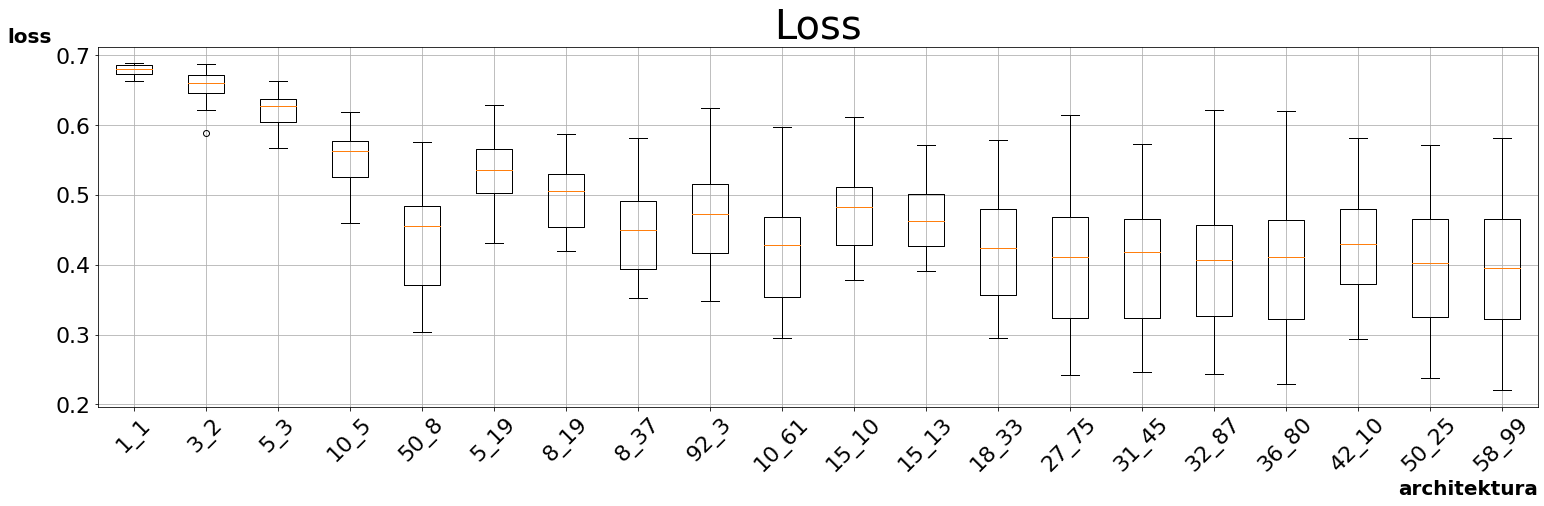

In [4]:
data = []
labels = []
# Creating dataset
for key in small_datasets:
    labels.append(key)
    data.append([i[0] for i in small_datasets[key]])

boxplot(data, labels, 'Loss', 'loss')

C:\Users\vladka\miniconda3\envs\pythonProject\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


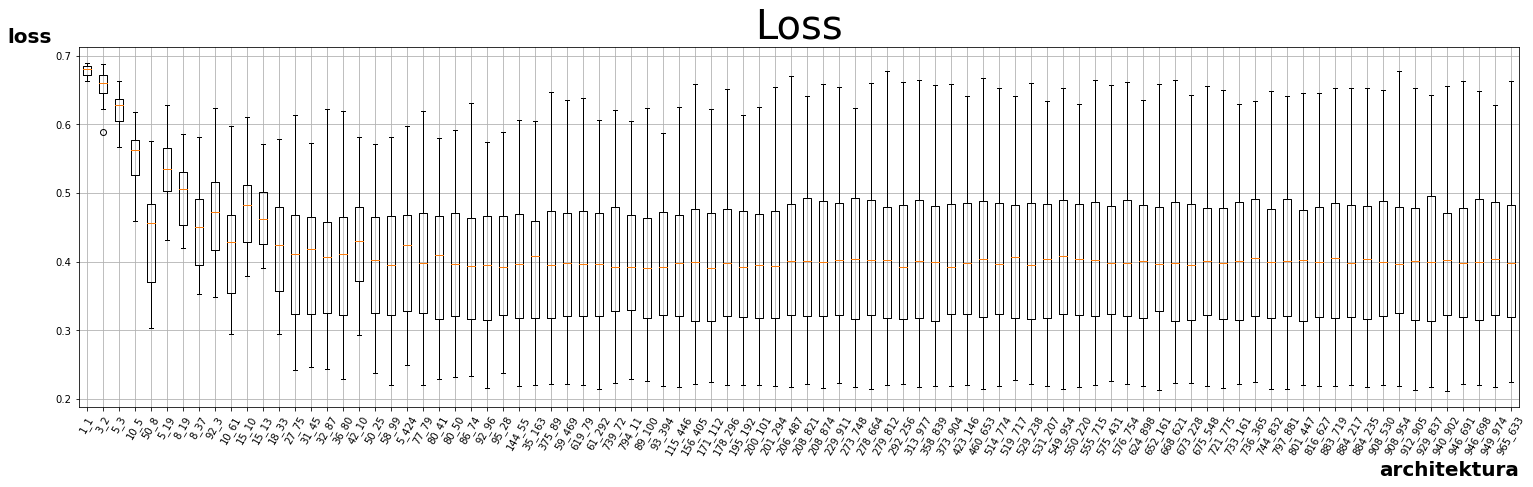

In [5]:
import numpy as np

data = []
data_means = []
labels = []
# Creating dataset
for key in datasets:
    labels.append(key)
    data.append([i[0] for i in datasets[key]])
    data_means.append(np.mean([i[0] for i in datasets[key]]))

boxplot(data, labels, 'Loss', 'loss', labelrotation=60, font_size=10)

C:\Users\vladka\miniconda3\envs\pythonProject\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


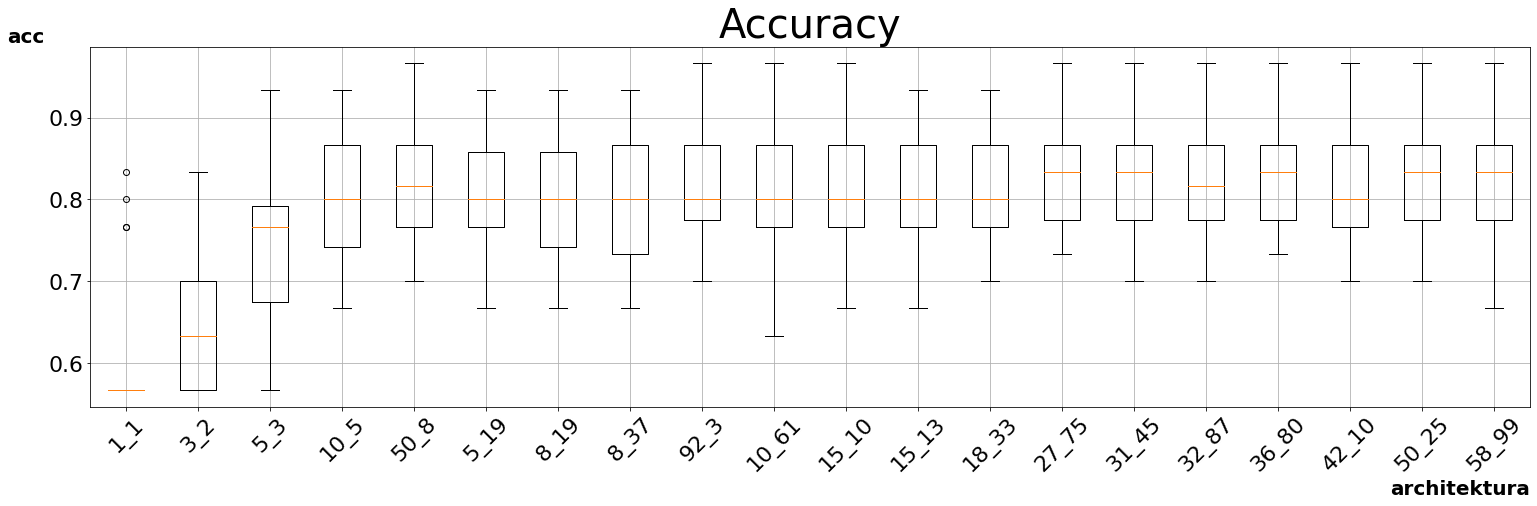

In [6]:
data = []
labels = []
# Creating dataset
for key in small_datasets:
    labels.append(key)
    data.append([i[1] for i in small_datasets[key]])

boxplot(data, labels, 'Accuracy', 'acc')

C:\Users\vladka\miniconda3\envs\pythonProject\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


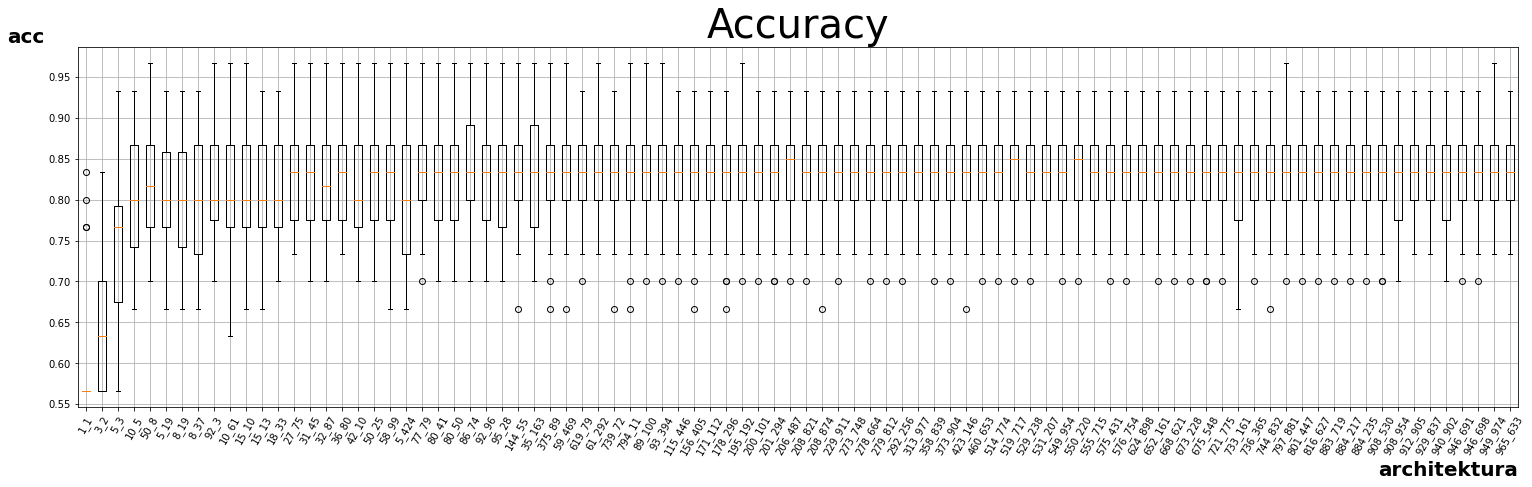

In [7]:
import numpy as np

data = []
data_means = []
labels = []
# Creating dataset
for key in datasets:
    labels.append(key)
    data.append([i[1] for i in datasets[key]])
    data_means.append(np.mean([i[1] for i in datasets[key]]))

boxplot(data, labels, 'Accuracy', 'acc', labelrotation=60, font_size=10)

In [30]:
# Ruzne testovane parametry neuronove site
layers = [['3', '2'], ['5', '3'], ['10', '5'], ['5', '19'], ['8', '19'], ['8', '37'], ['15', '10'], ['15', '13'],
          ['18', '33'], ['42', '10']]
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
batch_sizes = [1, 16, 32, 64, 128, 256]
epochs = [100, 200, 500]
optimizers = ['Adam', 'SGD', 'Adamax', 'Nadam']

In [31]:
# Vypocet ocekavaneho poctu slozek pro kontrolu behu
count = 0
for layer in layers:
    layer1 = layer[0]
    layer2 = layer[1]
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for epoch in epochs:
                for optimizer in optimizers:
                    count += 1
print(count)

3600


In [4]:
# optimizery byly meneny rucne
import tensorflow as tf

for layer in layers:
    layer1 = layer[0]
    layer2 = layer[1]
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for epoch in epochs:
                os.mkdir('../models2/layers{}_{}lrate{}bsize{}epochs{}Nadam'.format(layer1, layer2, learning_rate,
                                                                                    batch_size, epoch))
                pokusxx = []
                pokus = 'layers{}_{}lrate{}bsize{}epochs{}Nadam'.format(layer1, layer2, learning_rate, batch_size,
                                                                        epoch)
                os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
                for realizace in range(5):
                    np.random.seed(realizace)

                    # -- SETTINGS
                    DATA_FILE = 'heart.csv'  # source CSV file
                    DATA_SPLIT_RATIO = (0.8, 0.1, 0.1)  # (train, dev, test)

                    NET_PARAMS = {
                        'hidden_layers': [layer1, layer2],
                        'learning_rate': learning_rate,
                        'loss': 'binary_crossentropy',
                        'metrics': ['accuracy'],
                        'epochs': epoch,
                        'batch_size': batch_size,
                        'do_fit': True,
                        'overwrite_best_model': False
                    }

                    ## -- DATA PREPROCESSING

                    # Read and normalize data, sort features
                    samples, targets, feats = read_data(data_file=DATA_FILE)

                    # Get basic data stats (you can print all samples to check)
                    show_data_stats(samples, targets, print_data=False)

                    # Split data (train, dev, test)
                    split = split_data(targets, DATA_SPLIT_RATIO, seed=realizace)

                    # Form data for Keras
                    data = form_data(samples, targets, split, feats)

                    ## -- NEURAL NETWORK DESIGN

                    # Network architecture
                    model = design_model(inp_shape=data['x_train'][0].shape, out_units=1, params=NET_PARAMS)

                    # Optimizer
                    optimizer = tf.keras.optimizers.Nadam(learning_rate=NET_PARAMS['learning_rate'])

                    # Network compilation
                    model.compile(loss=NET_PARAMS['loss'], optimizer=optimizer, metrics=NET_PARAMS['metrics'])

                    ## -- NEURAL NETWORK TRAINING

                    # Save the best gained model to this path
                    if NET_PARAMS['overwrite_best_model']:
                        best_model_path = '../models/best.h5'
                    else:
                        best_model_path = '../models2/{}/model_{}.h5'.format(pokus, realizace)

                    # Train the network
                    if NET_PARAMS['do_fit']:
                        model.fit(data['x_train'], data['y_train'],
                                  validation_data=(data['x_dev'], data['y_dev']),
                                  epochs=NET_PARAMS['epochs'],
                                  batch_size=NET_PARAMS['batch_size'],
                                  shuffle=True,
                                  verbose=False,
                                  callbacks=[ModelCheckpoint(best_model_path, monitor='val_loss', verbose=False,
                                                             save_best_only=True, save_weights_only=False)])

                    ## -- NEURAL NETWORK EVALUATION

                    # Load model for evaluation
                    evaluated_model = best_model_path
                    print(best_model_path)
                    #evaluated_model = 'path_to_your_model_for_evaluation'

                    model = load_model(evaluated_model)

                    # Evaluate on test data
                    y_pred = model.predict(data['x_test'])

                    test_loss, test_acc = model.evaluate(data['x_test'], data['y_test'])
                    print(test_loss, test_acc)
                    pokusxx.append([test_loss, test_acc])
                    print()

                #    for yi, ui in zip(y_pred, data['y_test']):
                #        print(yi[0], ui[0])
                with open('../models2/{}/data.txt'.format(pokus), 'w') as file:
                    file.write(str(pokusxx))

../models2/layers18_33lrate0.1bsize1epochs100Nadam/model_0.h5
1/1 [==============================] - 0s 0s/step - loss: 0.4840 - accuracy: 0.8333
0.483976811170578 0.8333333134651184

../models2/layers18_33lrate0.1bsize1epochs100Nadam/model_1.h5
1/1 [==============================] - 0s 0s/step - loss: 0.3808 - accuracy: 0.8667
0.380803644657135 0.8666666746139526

../models2/layers18_33lrate0.1bsize1epochs100Nadam/model_2.h5
1/1 [==============================] - 0s 2ms/step - loss: 0.5113 - accuracy: 0.7333
0.5112903714179993 0.7333333492279053

../models2/layers18_33lrate0.1bsize1epochs100Nadam/model_3.h5
1/1 [==============================] - 0s 0s/step - loss: 0.4316 - accuracy: 0.8000
0.43161740899086 0.800000011920929

../models2/layers18_33lrate0.1bsize1epochs100Nadam/model_4.h5
1/1 [==============================] - 0s 0s/step - loss: 0.3655 - accuracy: 0.8000
0.365451842546463 0.800000011920929

../models2/layers18_33lrate0.1bsize1epochs200Nadam/model_0.h5
1/1 [==============

In [8]:
import ast
import os

folders = next(os.walk('../models2/'))[1]
folders = sorted(folders, key=len)
datasets = dict()
for folder in folders:
    with open('../models2/{}/data.txt'.format(folder), 'r') as f:
        data = f.readlines()
        data = ast.literal_eval(data[0])
    datasets[folder] = data

In [11]:
def plot_means(data, title, yax, labelrotation=45, font_size=22):
    import matplotlib.pyplot as plt
    global fig, ax
    fig = plt.figure(figsize=(20, 5))
    plt.rcParams.update({'font.size': font_size})
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    # Creating plot
    plt.plot(data)
    # show plot
    plt.title(label=title,
              fontsize=40)
    plt.xlabel("architektura",
               fontweight='bold',
               fontsize=20,
               loc="right")
    plt.ylabel(yax, rotation=0,
               fontweight='bold',
               fontsize=20,
               loc="top")
    plt.tick_params(axis='x', labelrotation=labelrotation)
    plt.grid()
    # show plot
    # plt.savefig('loss_big.svg',bbox_inches='tight', dpi=150)
    plt.show()

In [9]:
def plot_hist(data, title, xax, cummulative = False, labelrotation=45, font_size=22):
    import matplotlib.pyplot as plt
    global fig, ax
    fig = plt.figure(figsize=(20, 5))
    plt.rcParams.update({'font.size': font_size})
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    # Creating plot
    plt.hist(data, cumulative=cummulative, bins=256)

    plt.title(label=title,
              fontsize=40)
    plt.xlabel(xax,
               fontweight='bold',
               fontsize=20,
               loc="right")
    plt.ylabel('pocet realizaci', rotation=0,
               fontweight='bold',
               fontsize=20,
               loc="top")
    plt.tick_params(axis='x', labelrotation=labelrotation)
    plt.grid()


    fig = plt.figure(figsize=(20, 5))
    # Creating plot
    plt.hist(data, cumulative=False, bins=256)
    # show plot
    plt.title(label=title,
              fontsize=40)
    plt.xlabel(xax,
               fontweight='bold',
               fontsize=20,
               loc="right")
    plt.ylabel('pocet realizaci', rotation=0,
               fontweight='bold',
               fontsize=20,
               loc="top")
    plt.tick_params(axis='x', labelrotation=labelrotation)
    plt.grid()
    # show plot
    # plt.savefig('loss_big.svg',bbox_inches='tight', dpi=150)
    plt.show()

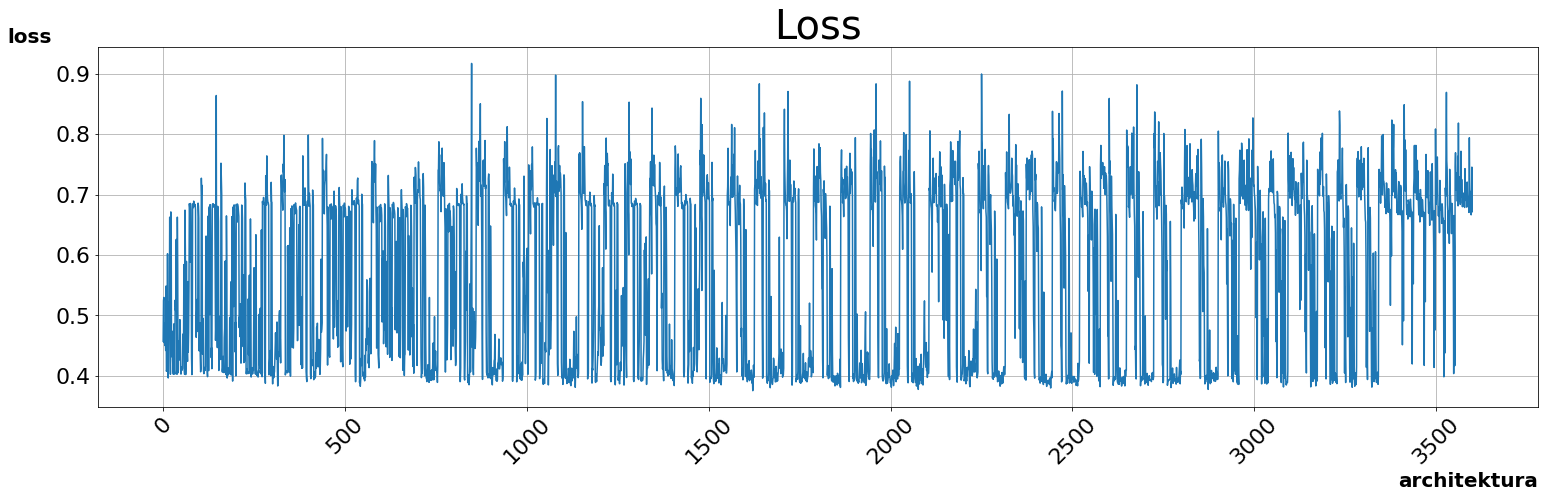

In [12]:
import numpy as np

data = []
data_means = []
# Creating dataset
for key in datasets:
    data.append([i[0] for i in datasets[key]])
    data_means.append(np.mean([i[0] for i in datasets[key]]))

plot_means(data_means, 'Loss', 'loss')

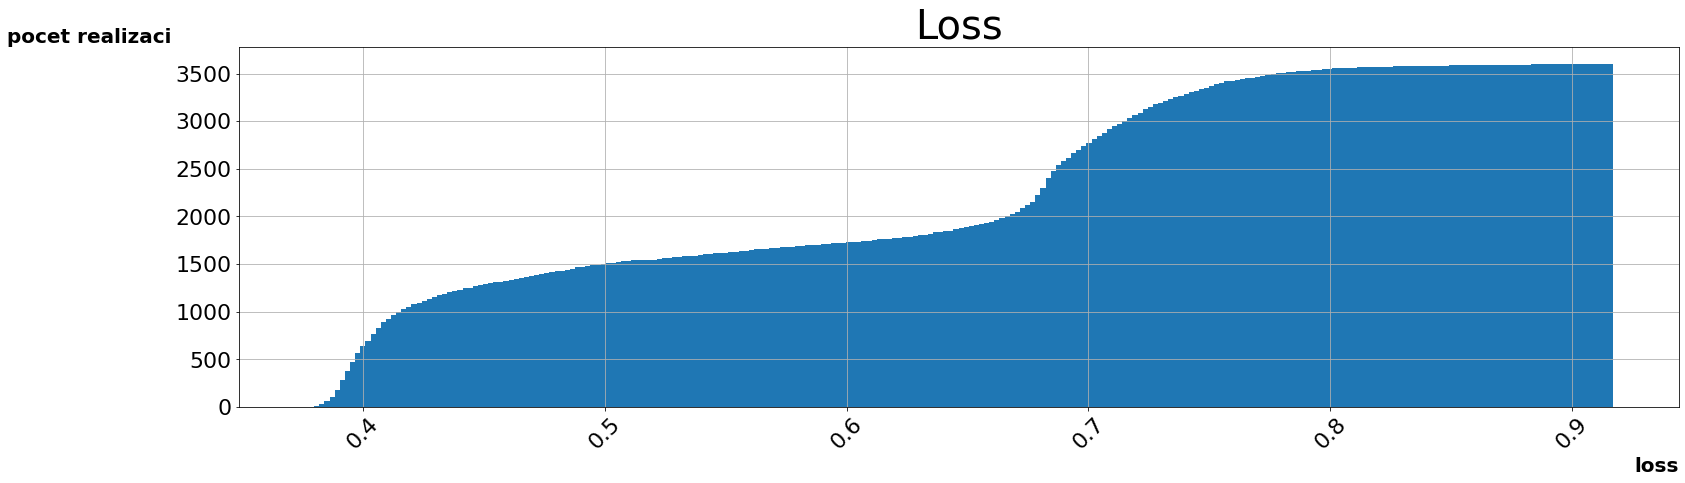

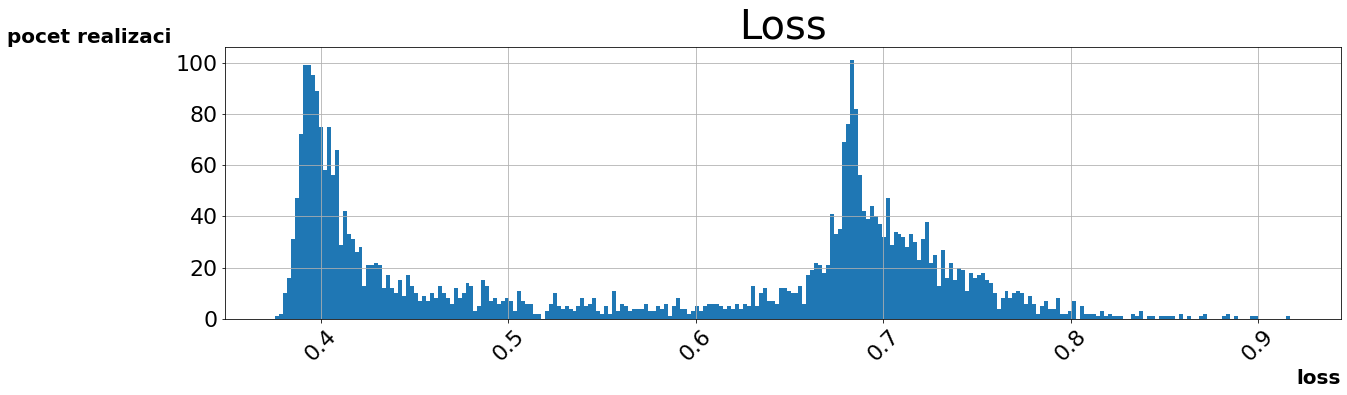

In [13]:
plot_hist(data_means, 'Loss', 'loss', cummulative = True, labelrotation=45, font_size=22)

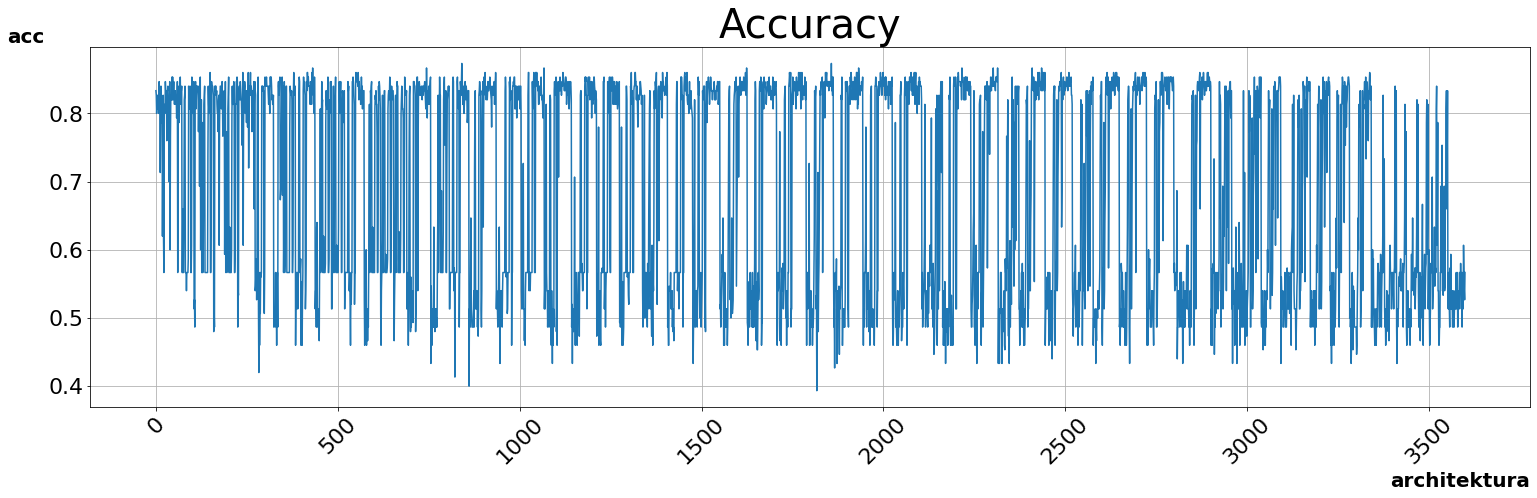

In [14]:
import matplotlib.pyplot as plt
import numpy as np

data = []
data_means = []
# Creating dataset
for key in datasets:
    data.append([i[1] for i in datasets[key]])
    data_means.append(np.mean([i[1] for i in datasets[key]]))

plot_means(data_means, 'Accuracy', 'acc')

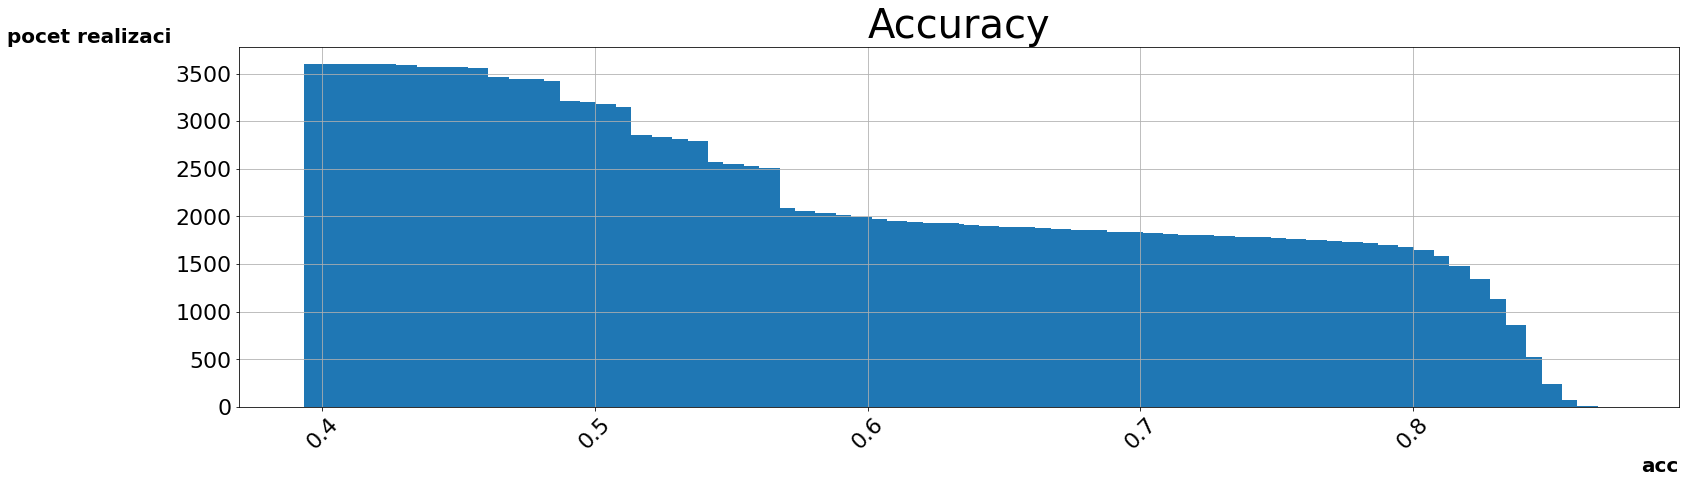

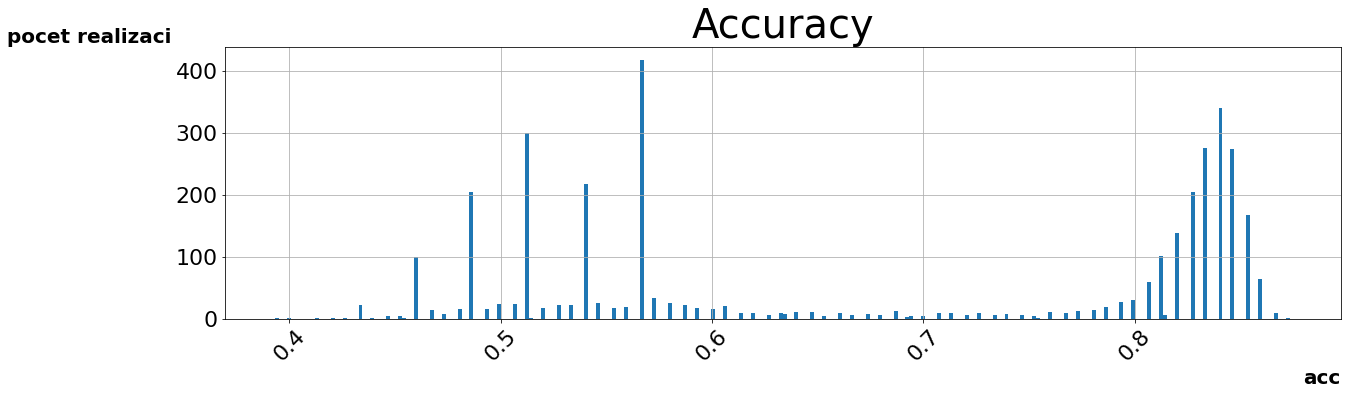

In [15]:
plot_hist(data_means, 'Accuracy', 'acc', cummulative = -1, labelrotation=45, font_size=22)

In [14]:
import numpy as np
datasets_good = {}
for key in datasets:
    if (np.mean([i[0] for i in datasets[key]])) < 0.384:
        datasets_good[key] = datasets[key]

C:\Users\vladka\miniconda3\envs\pythonProject\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


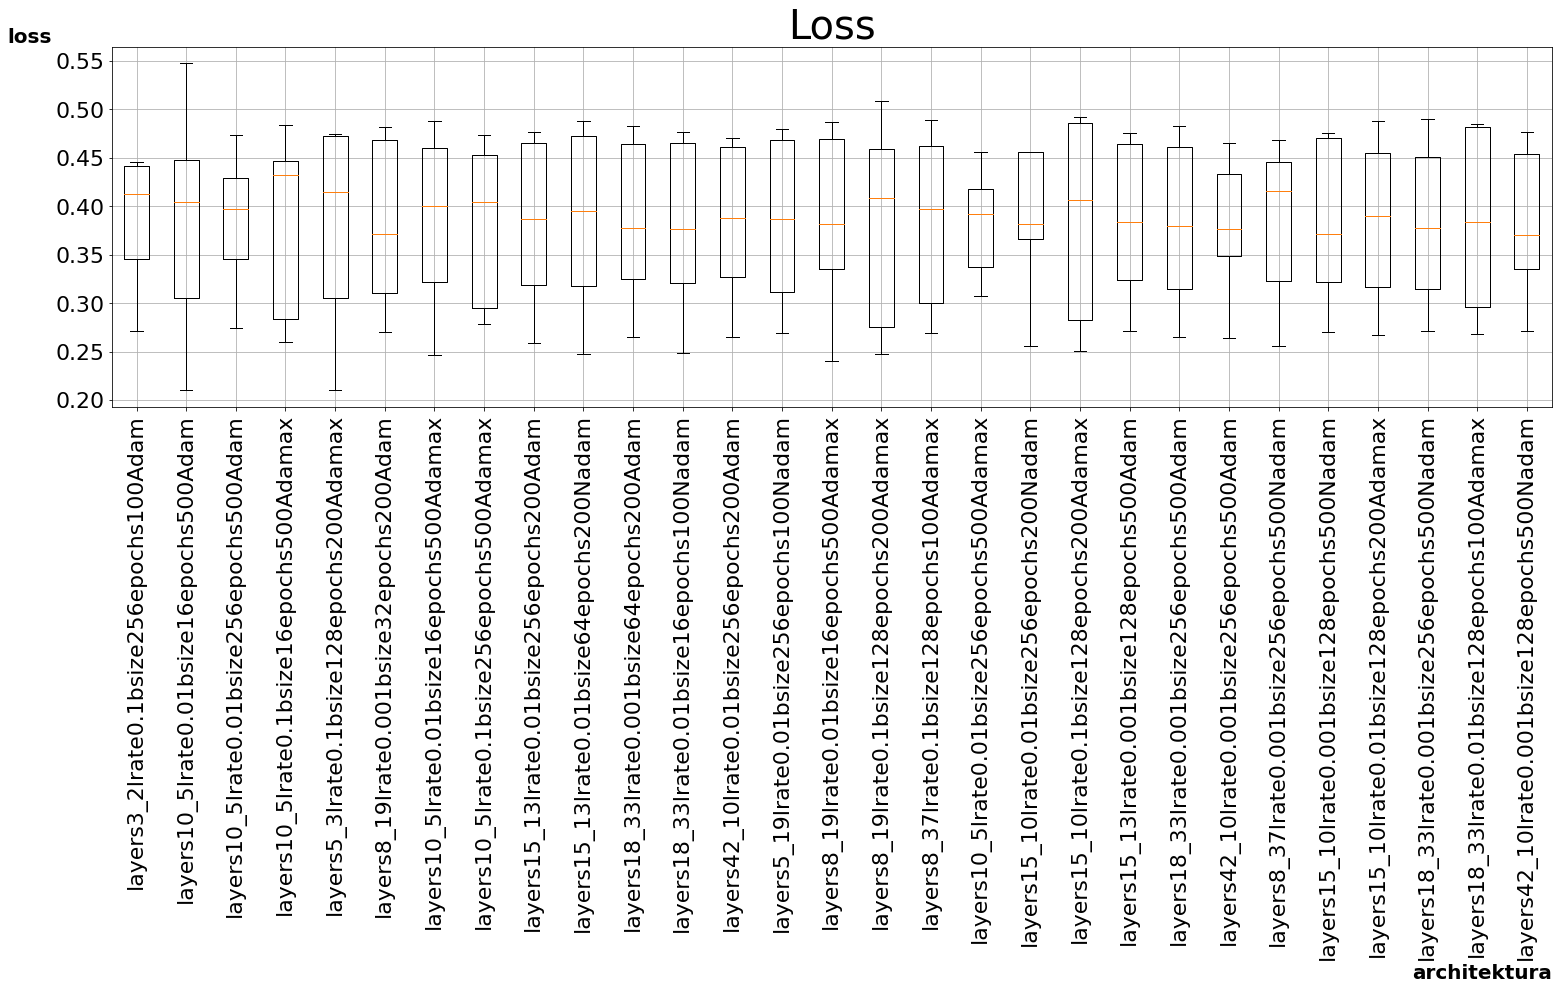

In [15]:
import numpy as np

data = []
labels = []
# Creating dataset
for key in datasets_good:
    labels.append(key)
    data.append([i[0] for i in datasets_good[key]])

boxplot(data, labels, 'Loss', 'loss', labelrotation=90)

In [16]:
datasets_good = {}
for key in datasets:
    if (np.mean([i[1] for i in datasets[key]])) > 0.86:
        datasets_good[key] = datasets[key]

C:\Users\vladka\miniconda3\envs\pythonProject\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


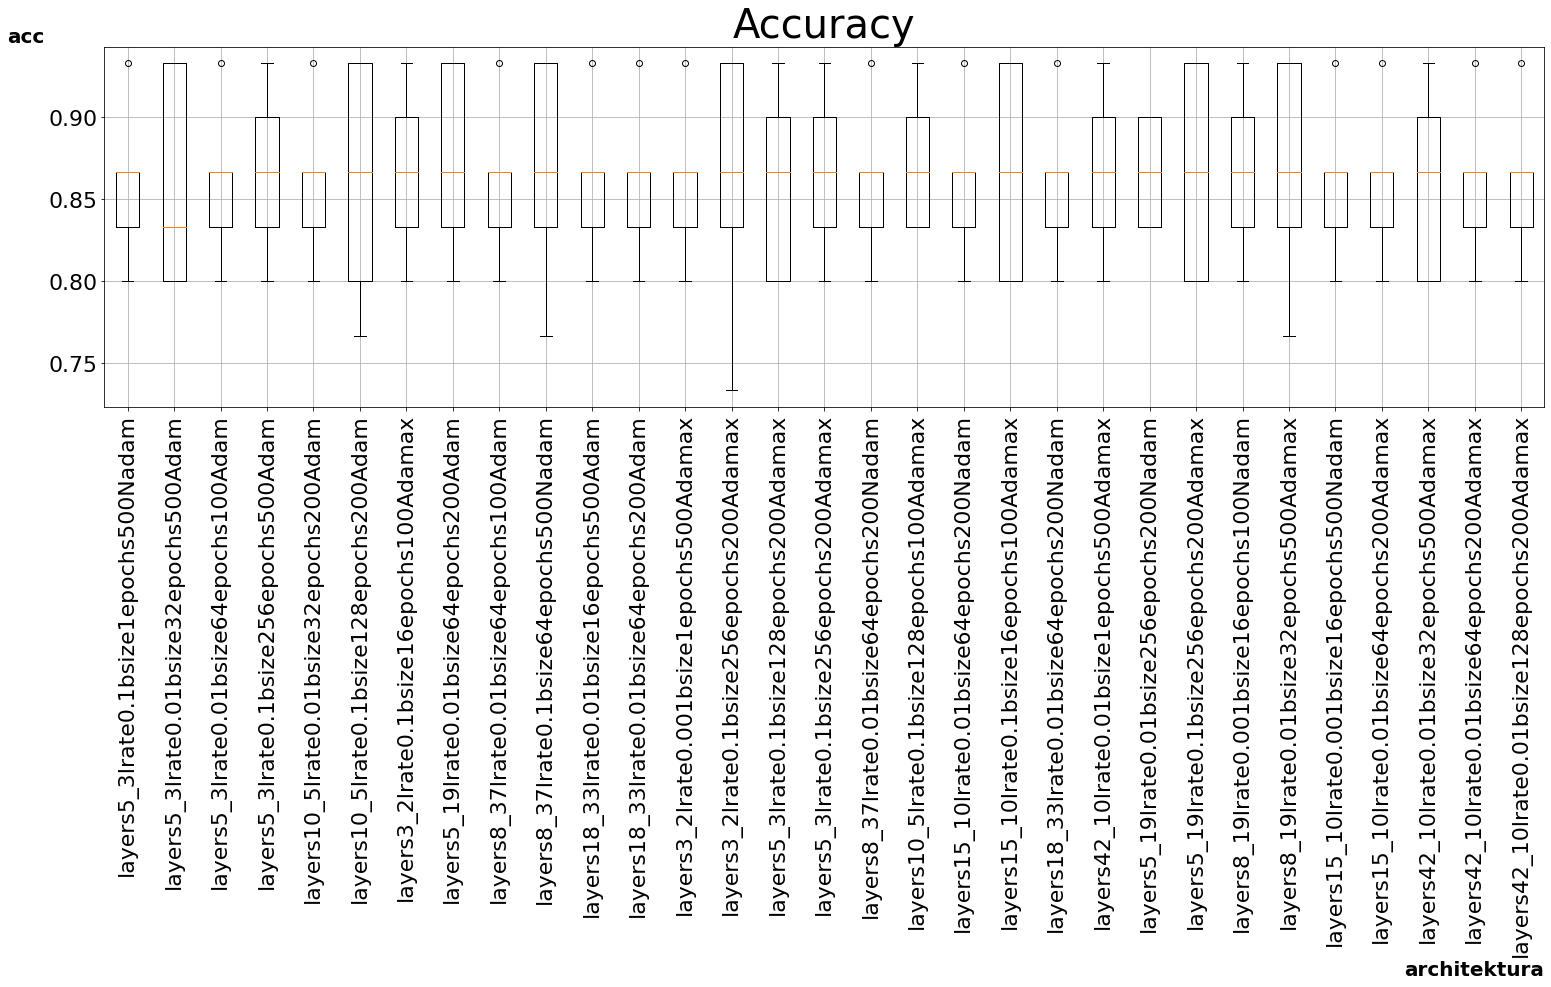

In [17]:
import numpy as np

data = []
labels = []
# Creating dataset
for key in datasets_good:
    labels.append(key)
    data.append([i[1] for i in datasets_good[key]])

boxplot(data, labels, 'Accuracy', 'acc', labelrotation=90)

In [18]:
datasets_best = {}
for key in datasets:
    if (np.mean([i[1] for i in datasets[key]])) > 0.86 and (np.mean([i[0] for i in datasets[key]])) < 0.384:
        datasets_best[key] = datasets[key]

In [78]:
# Natrenovani modelu s nejlepsimi parametry z pokusu pro 30 seedu
pokusxx = []
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
for realizace in range(30):
    # -- SETTINGS
    DATA_FILE = 'heart.csv'  # source CSV file
    DATA_SPLIT_RATIO = (0.8, 0.1, 0.1)  # (train, dev, test)

    NET_PARAMS = {
        'hidden_layers': [5, 3],
        'learning_rate': 0.1,
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy'],
        'epochs': 200,
        'batch_size': 128,
        'do_fit': True,
        'overwrite_best_model': False
    }

    ## -- DATA PREPROCESSING

    # Read and normalize data, sort features
    samples, targets, feats = read_data(data_file=DATA_FILE)

    # Get basic data stats (you can print all samples to check)
    show_data_stats(samples, targets, print_data=False)

    # Split data (train, dev, test)
    split = split_data(targets, DATA_SPLIT_RATIO, seed=realizace)

    # Form data for Keras
    data = form_data(samples, targets, split, feats)

    ## -- NEURAL NETWORK DESIGN

    # Network architecture
    model = design_model(inp_shape=data['x_train'][0].shape, out_units=1, params=NET_PARAMS)

    # Optimizer
    optimizer = tf.keras.optimizers.Adamax(learning_rate=NET_PARAMS['learning_rate'])

    # Network compilation
    model.compile(loss=NET_PARAMS['loss'], optimizer=optimizer, metrics=NET_PARAMS['metrics'])

    ## -- NEURAL NETWORK TRAINING

    # Save the best gained model to this path
    if NET_PARAMS['overwrite_best_model']:
        best_model_path = '../best_model/best.h5'
    else:
        best_model_path = '../best_model/{}.h5'.format(realizace)

    # Train the network
    if NET_PARAMS['do_fit']:
        model.fit(data['x_train'], data['y_train'],
                  validation_data=(data['x_dev'], data['y_dev']),
                  epochs=NET_PARAMS['epochs'],
                  batch_size=NET_PARAMS['batch_size'],
                  shuffle=True,
                  verbose=False,
                  callbacks=[ModelCheckpoint(best_model_path, monitor='val_loss', verbose=False, save_best_only=True,
                                             save_weights_only=False)])

    ## -- NEURAL NETWORK EVALUATION

    # Load model for evaluation
    evaluated_model = best_model_path
    print(best_model_path)
    #evaluated_model = 'path_to_your_model_for_evaluation'

    model = load_model(evaluated_model)

    # Evaluate on test data
    y_pred = model.predict(data['x_test'])

    test_loss, test_acc = model.evaluate(data['x_test'], data['y_test'])
    print(test_loss, test_acc)
    pokusxx.append([test_loss, test_acc])
    print()

#    for yi, ui in zip(y_pred, data['y_test']):
#        print(yi[0], ui[0])
with open('../best_model/data.txt', 'w') as file:
    file.write(str(pokusxx))

../best_model/0.h5
1/1 [==============================] - 0s 0s/step - loss: 0.4443 - accuracy: 0.8333
0.44432076811790466 0.8333333134651184

../best_model/1.h5
1/1 [==============================] - 0s 1ms/step - loss: 0.3405 - accuracy: 0.9333
0.3405478894710541 0.9333333373069763

../best_model/2.h5
1/1 [==============================] - 0s 0s/step - loss: 0.5054 - accuracy: 0.8000
0.5054337978363037 0.800000011920929

../best_model/3.h5
1/1 [==============================] - 0s 0s/step - loss: 0.4179 - accuracy: 0.8333
0.41787177324295044 0.8333333134651184

../best_model/4.h5
1/1 [==============================] - 0s 0s/step - loss: 0.2684 - accuracy: 0.8667
0.2684215307235718 0.8666666746139526

../best_model/5.h5
1/1 [==============================] - 0s 0s/step - loss: 0.4686 - accuracy: 0.8333
0.468565434217453 0.8333333134651184

../best_model/6.h5
1/1 [==============================] - 0s 0s/step - loss: 0.6507 - accuracy: 0.8000
0.650738537311554 0.800000011920929

../best

In [19]:
import ast

with open('../best_model/data.txt', 'r') as f:
    data = f.readlines()
    data = ast.literal_eval(data[0])

In [20]:
loss = []
acc = []
loss = loss + ([i[0] for i in data])
acc = acc + ([i[1] for i in data])

C:\Users\vladka\miniconda3\envs\pythonProject\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


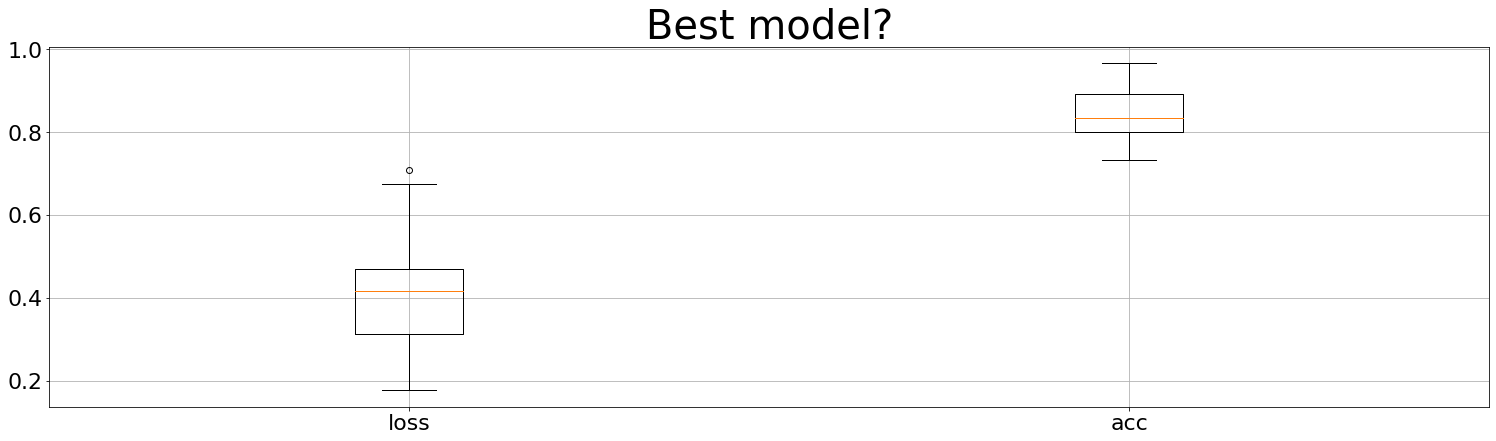

In [27]:
boxplot([loss, acc], ['loss', 'acc'], 'Best model?', None, None, labelrotation=0)

In [5]:
import numpy as np
import tensorflow as tf
# Natrenovani nejlepsiho modelu pro nejlepsi seed
pokusxx = []
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# -- SETTINGS
DATA_FILE = 'heart.csv'  # source CSV file
DATA_SPLIT_RATIO = (0.8, 0.1, 0.1)  # (train, dev, test)

NET_PARAMS = {
    'hidden_layers': [5, 3],
    'learning_rate': 0.1,
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy'],
    'epochs': 200,
    'batch_size': 128,
    'do_fit': True,
    'overwrite_best_model': True
}

## -- DATA PREPROCESSING

# Read and normalize data, sort features
samples, targets, feats = read_data(data_file=DATA_FILE)

# Get basic data stats (you can print all samples to check)
show_data_stats(samples, targets, print_data=False)

# Split data (train, dev, test)
split = split_data(targets, DATA_SPLIT_RATIO, seed=19)

# Form data for Keras
data = form_data(samples, targets, split, feats)

## -- NEURAL NETWORK DESIGN

# Network architecture
model = design_model(inp_shape=data['x_train'][0].shape, out_units=1, params=NET_PARAMS)

# Optimizer
optimizer = tf.keras.optimizers.Adamax(learning_rate=NET_PARAMS['learning_rate'])

# Network compilation
model.compile(loss=NET_PARAMS['loss'], optimizer=optimizer, metrics=NET_PARAMS['metrics'])

## -- NEURAL NETWORK TRAINING


# Save the best gained model to this path
if NET_PARAMS['overwrite_best_model']:
    best_model_path = '../best_model/best1.h5'
else:
    best_model_path = '../best_model/{}.h5'.format(19)

# Train the network
if NET_PARAMS['do_fit']:
    model.fit(data['x_train'], data['y_train'],
              validation_data=(data['x_dev'], data['y_dev']),
              epochs=NET_PARAMS['epochs'],
              batch_size=NET_PARAMS['batch_size'],
              shuffle=True,
              verbose=False,
              callbacks=[ModelCheckpoint(best_model_path, monitor='val_loss', verbose=False, save_best_only=True,
                                         save_weights_only=False)])

## -- NEURAL NETWORK EVALUATION

# Load model for evaluation
evaluated_model = best_model_path
print(best_model_path)
#evaluated_model = 'path_to_your_model_for_evaluation'

model = load_model(evaluated_model)

# Evaluate on test data
y_pred = model.predict(data['x_test'])

test_loss, test_acc = model.evaluate(data['x_test'], data['y_test'])
print(test_loss, test_acc)
pokusxx.append([test_loss, test_acc])
print()

#    for yi, ui in zip(y_pred, data['y_test']):
#        print(yi[0], ui[0])

../best_model/best1.h5
1/1 [==============================] - 0s 0s/step - loss: 0.1435 - accuracy: 0.9667
0.14350563287734985 0.9666666388511658

